In [34]:
import os
import operator
import random
import calendar
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from vixstructure.data import FuturesByMonth, LongPricesDataset
from vixstructure.utils import parse_whole_directory_monthwise
from vixstructure.models import term_structure_to_single_spread_price

mpl.rcParams["figure.figsize"] = 16, 9

In [2]:
def plot3d_loss(dataframe, zlim=None, rotation=225):
    X = dataframe.index.levels[0]
    Y = dataframe.index.levels[1]
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(
            np.array(list(map(lambda x: dataframe[x[0], x[1]], np.reshape(np.dstack((X,Y)), (X.shape[0]*X.shape[1],2))))),
            X.shape)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, linewidth=None, antialiased=True, cmap=cm.coolwarm_r)
    ax.view_init(azim=rotation)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Width")
    ax.set_xlim(X[0,0], X[-1,-1])
    ax.set_ylim(Y[0,0], Y[-1,-1])
    ax.set_zlim(zlim)
    #ax.set_zlabel("Loss", rotation=90)

In [3]:
data = parse_whole_directory_monthwise("models/experiment10/")
data2 = parse_whole_directory_monthwise("models/experiment08.6/")

In [4]:
min_dat = data.append(data2).groupby(("depth", "width", "month", "datetime")).min()

In [5]:
mean_month = min_dat.groupby(("depth", "width", "month")).mean().groupby(("depth", "width")).mean()

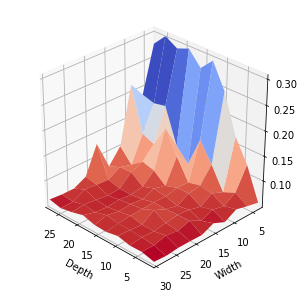

In [6]:
plot3d_loss(mean_month.val_loss, rotation=135)
plt.savefig("approach2-diff_yearly.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
mean_month.val_loss.sort_values()

depth  width
1      27       0.051055
       30       0.052697
       18       0.053001
       12       0.053507
       24       0.053688
       21       0.053743
       3        0.055586
4      15       0.056358
25     30       0.056686
       27       0.057550
22     21       0.057972
7      30       0.058535
4      27       0.058732
       30       0.059119
19     24       0.059261
       18       0.059405
13     30       0.059586
7      12       0.059821
22     18       0.060016
28     24       0.060113
       27       0.060189
16     30       0.060676
7      24       0.060685
1      6        0.060772
19     27       0.060841
4      9        0.061058
22     30       0.061169
10     24       0.061318
22     24       0.061336
10     15       0.061550
                  ...   
4      6        0.076401
10     21       0.077945
       9        0.078503
25     15       0.080821
22     15       0.082128
19     12       0.085833
16     6        0.087885
22     12       0.092446
28     12   

# Now load some real models trained

In [8]:
_, _, files = next(os.walk("models/experiment10.1/"))
weights = [file for file in files if os.path.splitext(file)[1] == ".h5"]
weights.sort(key=lambda x: int(x.split("_")[4][5:]))

In [9]:
naive = []
predict = []
for month, weight in zip(range(1, 13), weights):
    futures = FuturesByMonth("data/futures_per_year_and_month.h5", month, yearly=True, spreads=True)
    datasets = futures.splitted_dataset()
    model = term_structure_to_single_spread_price(1, 30, input_data_length=12)
    model.load_weights("models/experiment10.1/" + weight)
    naive_m = []
    predict_m = []
    for x, y in datasets:
        naive_m.append(np.mean(np.square(x[:, month-1] - y[:, 0])))
        predict_m.append(np.mean(np.square(model.predict(x) - y)))
    naive.append(naive_m)
    predict.append(predict_m)
naive = np.array(naive)
predict = np.array(predict)

In [10]:
naive = pd.DataFrame(naive, index=calendar.month_abbr[1:], columns=["Training", "Validation", "Test"])
predict = pd.DataFrame(predict, index=calendar.month_abbr[1:], columns=["Training", "Validation", "Test"])

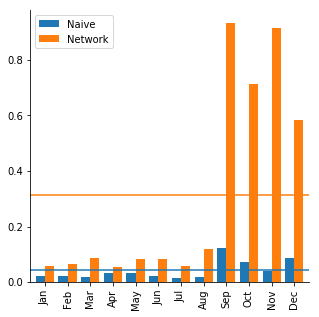

In [11]:
ax = pd.concat([naive.Test, predict.Test], axis=1, keys=["Naive", "Network"]).plot.bar(figsize=(5, 5), width=0.8)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.axhline(naive.Test.mean(), color="#1f77b4")
plt.axhline(predict.Test.mean(), color="#ff7f0e")
plt.savefig("approach2-naive-comparison.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
predict.Test.mean()

0.31207166495735789

# Experiment 11

In [98]:
data11 = parse_whole_directory_monthwise("models/experiment11/")

In [99]:
min_dat11 = data11.groupby(("depth", "width", "month", "datetime")).min()

In [100]:
dat11_mean = min_dat11.groupby(("depth", "width", "month")).mean()
dat11_std = min_dat11.groupby(("depth", "width", "month")).std()

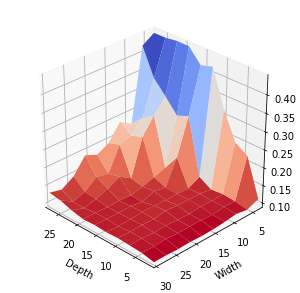

In [111]:
plot3d_loss(dat11_mean.groupby(("depth", "width")).mean().val_loss, rotation=135)
plt.savefig("approach2-legwise.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

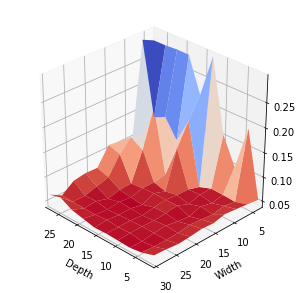

In [108]:
plot3d_loss(dat11_mean.groupby(("depth", "width")).std().val_loss, rotation=135)
plt.show()

In [46]:
_, _, files = next(os.walk("models/experiment11.1/"))
weights = [file for file in files if os.path.splitext(file)[1] == ".h5"]
weights.sort(key=lambda x: int(x.split("_")[4][5:]))

In [52]:
naive = []
predict = []
prices = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")
for month, weight in zip(range(1, 13), weights):
    datasets = prices.splitted_dataset(leg=month)
    model = term_structure_to_single_spread_price(1, 30, input_data_length=7)
    model.load_weights("models/experiment11.1/" + weight)
    naive_m = []
    predict_m = []
    for x, y in datasets:
        naive_m.append(np.mean(np.square(y[:-1, 0] - y[1:, 0])))
        predict_m.append(np.mean(np.square(model.predict(x) - y)))
    naive.append(naive_m)
    predict.append(predict_m)
naive = np.array(naive)
predict = np.array(predict)

In [53]:
naive = pd.DataFrame(naive, index=list(range(1, 7)), columns=["Training", "Validation", "Test"])
predict = pd.DataFrame(predict, index=list(range(1, 7)), columns=["Training", "Validation", "Test"])

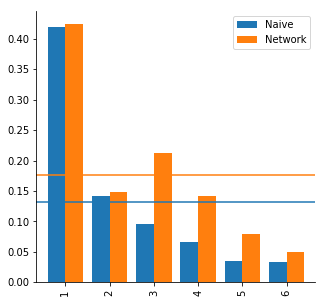

In [55]:
ax = pd.concat([naive.Test, predict.Test], axis=1, keys=["Naive", "Network"]).plot.bar(figsize=(5, 5), width=0.8)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.axhline(naive.Test.mean(), color="#1f77b4")
plt.axhline(predict.Test.mean(), color="#ff7f0e")
plt.savefig("approach2-ex2-naive-comparison.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

## Building a whole spread term structure

In [63]:
models = []
for weight in weights:
    model = term_structure_to_single_spread_price(1, 30, input_data_length=7)
    model.load_weights("models/experiment11.1/" + weight)
    models.append(model)

In [88]:
full_predict = []
_, _, (x_test, y_test) = prices.splitted_dataset()
for model in models:
    full_predict.append(model.predict(x_test[:, 1:-1])[:, 0])
full_predict = np.rollaxis(np.array(full_predict), 1, 0)

In [92]:
np.mean(np.square(full_predict - y_test))

0.17604978642788455